In [68]:
import numpy as np
import pandas as pd
import gensim 
from gensim import models
from gensim import corpora, models, similarities
from gensim.models.doc2vec import Doc2Vec, TaggedDocument
from collections import defaultdict
import nltk
import matplotlib.pyplot as plt
import umap
from sklearn.preprocessing import StandardScaler
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder
from imblearn.over_sampling import SMOTE
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression

In [30]:
data = pd.read_csv("tagged_translated_data.csv")

tagged_data = data[["ID_SERVICE_REVIEW", "Tags", "DS_TEXT_TRANSLATED"]][data["Tags"].isna()==False]

untagged_data = data[["ID_SERVICE_REVIEW", "DS_TEXT_TRANSLATED"]][data["Tags"].isna()==True]

X_train, X_test, y_train, y_test = train_test_split(tagged_data[["DS_TEXT_TRANSLATED", "Tags"]], tagged_data["Tags"], test_size=0.33, random_state=0)


## Doc2Vec

In [43]:

def tokenize_text(text):
    tokens = []
    for sent in nltk.sent_tokenize(text):
        for word in nltk.word_tokenize(sent):
            if len(word) < 2:
                continue
            tokens.append(word.lower())
    return tokens

def d2v_classifier(train_docs:np.ndarray, classes:np.ndarray, test_docs:np.ndarray, topn:int = 5, workers=1, vector_size = 4, epochs=20, dm=1):
    """Classify documents according to desired classes. 
    
    train_docs and test_docs must contain only the text of the documents, while
    classes contains the tags for the training documents. 
    
    """
    
    train_data = pd.DataFrame({"docs": train_docs, "tag":classes})
    train_tagged = train_data.apply(
        lambda r: TaggedDocument(words=tokenize_text(r['docs']), tags=[r.tag]), axis=1)
    
    trainsent = train_tagged.values
    
    doc2vec_model = Doc2Vec(trainsent, workers=workers, vector_size=vector_size, epochs=epochs, dm=dm)
    
    train_targets, train_regressors = zip(
        *[(doc.tags[0], doc2vec_model.infer_vector(doc.words)) for doc in trainsent])
    
    inferred_test_vectors = [doc2vec_model.infer_vector(doc.split()) for doc in test_docs]
    
    knn_test_predictions = [
        doc2vec_model.dv.most_similar([pred_vec], topn=topn)[0][0]
        for pred_vec in inferred_test_vectors
    ]
    
    predictions = pd.DataFrame({"doc":test_docs, "class": knn_test_predictions})
    
    return predictions

def doc2vec_viz(y_test, preds):
    labels = ['Customer Service', 'Delivery Service', 'Mixed', 'Other', 'Product Quality',]

    conf_mat = confusion_matrix(y_test, preds)
    fig, ax = plt.subplots(figsize=(10,10))
    sns.heatmap(conf_mat, annot=True, fmt='d', xticklabels=labels, yticklabels=labels)
    plt.ylabel('Actual')
    plt.xlabel('Predicted')
    plt.title("Heatmap of Doc2Vec Classification")

def doc2vec_pipeline(tagged_data, untagged_data, topn:int = 5, workers=1, vector_size = 4, epochs=20, dm=1):
    train_docs = tagged_data["DS_TEXT_TRANSLATED"]
    classes = tagged_data["Tags"]
    test_docs = untagged_data["DS_TEXT_TRANSLATED"]
    
    preds = d2v_classifier(train_docs, classes, test_docs, topn, workers, vector_size, epochs, dm)
    
    return preds
    
    

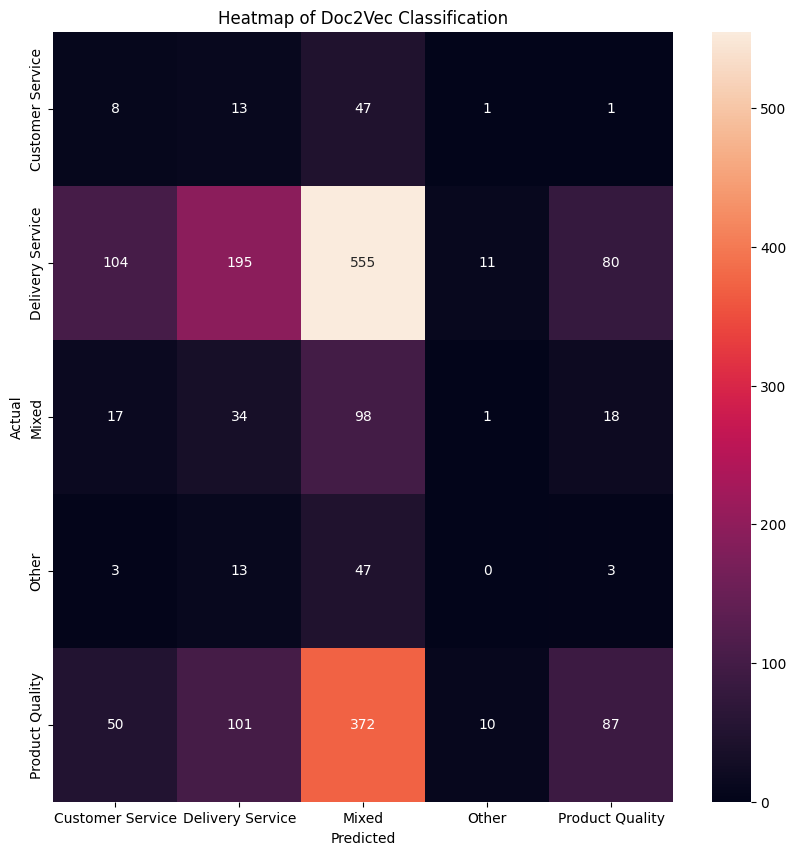

In [49]:
preds = doc2vec_pipeline(X_train, X_test)

doc2vec_viz(y_test, preds['class'])

## Logit+SMOTE

In [98]:

def logit_preprocess_supervised(tagged_data, test_size:float, random_state:int):
    """Transform text into a vectorized form and split the data into
    training and testing sets for a supervised version of the 
    classification, suitable for examining the performance of the model
    
    tagged data should contain only data which has full tags, and 
    must include both the text and the tags
    """
    
    before_vect = tagged_data[["DS_TEXT_TRANSLATED"]]

    columnTransformer = ColumnTransformer([('E',OneHotEncoder(dtype='int'),["DS_TEXT_TRANSLATED"]),
                                           ('tfidf',TfidfVectorizer(stop_words=None, max_features=100000), 'DS_TEXT_TRANSLATED')], 
                                          remainder='drop')
    vector_transformer = columnTransformer.fit(before_vect)
    vectorized_df = vector_transformer.transform(before_vect)
    y = tagged_data["Tags"]
    y=y.to_frame()
    
    X_train, X_test, y_train, y_test = train_test_split(vectorized_df, tagged_data["Tags"], test_size=test_size, random_state=random_state)

    return X_train, X_test, y_train, y_test


def logit_preprocess_unsupervised(data):
    """Transform text into a vectorized form and split into
    tagged and untagged subsets. it is necessary to perform the split after vectorizing, since the
    model we train later will require the same number of features. 
    
    """
    before_vect = data[["DS_TEXT_TRANSLATED"]]

    columnTransformer = ColumnTransformer([('E',OneHotEncoder(dtype='int'),["DS_TEXT_TRANSLATED"]),
                                           ('tfidf',TfidfVectorizer(stop_words=None, max_features=100000), 'DS_TEXT_TRANSLATED')], 
                                          remainder='drop')
    vector_transformer = columnTransformer.fit(before_vect)
    vectorized_df = vector_transformer.transform(before_vect)
    
    tagged = vectorized_df[data["Tags"].isna()==False]
    
    untagged = vectorized_df[data["Tags"].isna()==True]
    
    y = data["Tags"][data["Tags"].isna()==False]
    y=y.to_frame()

    return tagged, untagged, y
    

In [99]:
def model_smote(X_train, y_train, max_iter:int=100):
    """Train a logistic regression + SMOTE model on the data created in 
    one of the logit_preprocess functions. 
    
    """

    smote = SMOTE(random_state=777,k_neighbors=5)
    X_smote,Y_smote = smote.fit_resample(X_train,y_train)

    model = LogisticRegression(max_iter = max_iter)
    model.fit(X_smote,Y_smote)
    
    return model
    
def heatmap(y_test, y_pred):

    labels = ['Customer Service', 'Delivery Service', 'Mixed', 'Other', 'Product Quality',]
    conf_mat = confusion_matrix(y_test, y_pred)
    fig, ax = plt.subplots(figsize=(10,10))
    sns.heatmap(conf_mat, annot=True, fmt='d', xticklabels=labels, yticklabels=labels)
    plt.ylabel('Actual')
    plt.xlabel('Predicted')
    plt.title("Heatmap of Logit+SMOTE Classification")

def logit_smote_pipeline(data, mode:str, test_size:float = 0.33, random_state:int = 0, max_iter:int = 100):
    """Note that this function does not take a pre-made
    train-test split: the training and testing data alike must be 
    vectorized together, but we neglect to vectorize the tags
    If we vectorize the tags, we risk data leaks
    
    We allow for both a 'supervised' mode whose performance can be visualized as a heatmap
    and an 'unsupervised' mode which is suited to classifying yet-unclassified data. 
    
    """
    
    if mode=="supervised":
        X_train, X_test, y_train, y_test = logit_preprocess_supervised(data, test_size, random_state)
        model = model_smote(X_train, y_train, max_iter = max_iter)
        
        y_pred = model.predict(X_test)
        
        heatmap(y_test, y_pred)
        
        return y_pred
    
    elif mode=="unsupervised":
        
        tagged, untagged, y = logit_preprocess_unsupervised(data)
        model = model_smote(tagged, y, max_iter = max_iter)
        
        y_pred = model.predict(untagged)
        
        return y_pred
    
    

CPU times: user 807 ms, sys: 16.1 ms, total: 823 ms
Wall time: 823 ms


array(['Mixed', 'Delivery Service', 'Delivery Service', ...,
       'Delivery Service', 'Product Quality', 'Product Quality'],
      dtype=object)

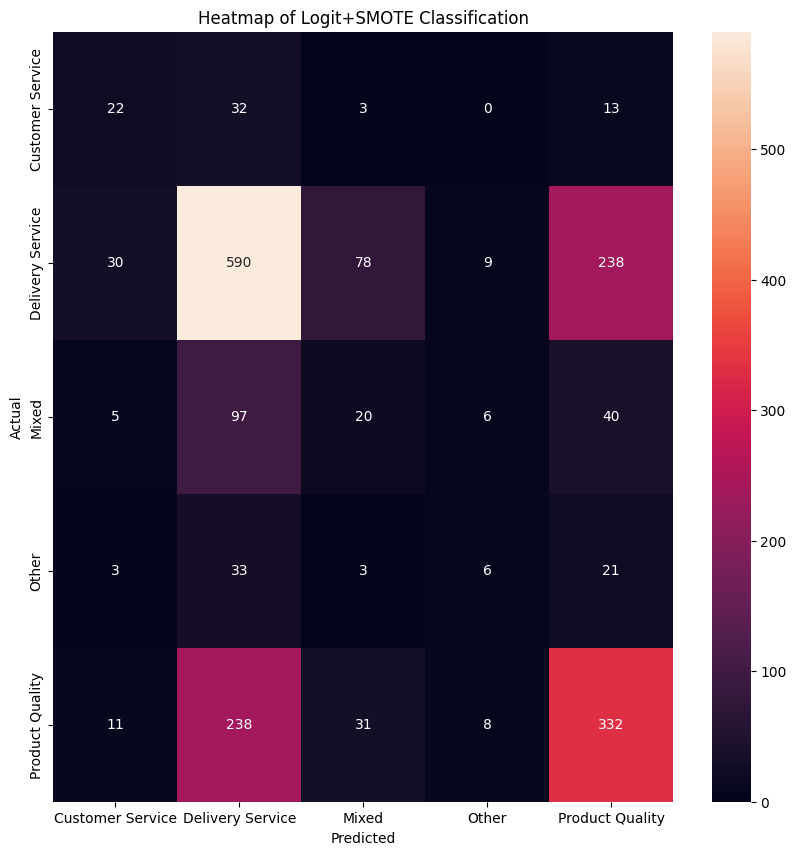

In [18]:
%%time

logit_smote_pipeline(tagged_data, "supervised", max_iter = 1000)